# Lab 3: SVM's, Kernel Tricks, Model Assessment and Selection [Classification, Part 2]

## Name: Varun Somani netid: vsomani2

## Due: February 11, 2016 12:00 AM [This is when Wednesday transitions to Thursday]

### Logistics

See the website.

### What You Will Need to Know For This Lab

* Kernel Tricks
* Support Vector Machines
* Model Assessment and Selection with Cross-Validation (especially don't train on your test data!)

### Preamble (don't change this)

In [1]:
%pylab inline
import numpy as np
from sklearn import neighbors
from sklearn import svm
from sklearn import cross_validation
from numpy import genfromtxt
from sklearn.lda import LDA
from sklearn.preprocessing import MinMaxScaler

Populating the interactive namespace from numpy and matplotlib


C:\Users\rock-\AppData\Local\Enthought\Canopy\User\lib\site-packages\sklearn\lda.py:4: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", DeprecationWarning)


### Problem 1: Cross-validation (25 points)

Write a function which implements $5$-fold cross-validation to estimate the error of a classifier with cross-validation with the 0,1-loss for k-Nearest Neighbors (kNN). 

You will be given as input:
* A (N,d) numpy.ndarray of training data, trainData (with N divisible by 5)
* A length $N$ numpy.ndarray of training labels, trainLabels
* A number $k$, for which cross-validated error estimates will be outputted for $1,\ldots,k$

Your output will be a vector (represented as a numpy.ndarray) err, such that err[i] is the cross-validated estimate of using i neighbors (err will be of length $k+1$; the zero-th component of the vector will be meaningless). 

So that this problem is easier to grade, take your folds to be 0:N/5, N/5:2N/5, ..., 4N/5:N for cross-validation (In general, the folds should be randomly divided).

Use scikit-learn's sklearn.neighbors.KNeighborsClassifier to perform the training and classification for the kNN models involved. Do not use any other features of scikit-learn, such as things from sklearn.cross_validation. <b>(10 points)</b>

In [2]:
def classifierError(truelabels,estimatedlabels):
    return float(np.sum(truelabels!=estimatedlabels))/truelabels.size
def crossValidationkNN(trainData,trainLabels,k):
    #Put your code here
    err=np.zeros(k+1)
    err[0]=100 # Set err[0] to some random meaningless value
    length = trainData.shape[0]
    for i in xrange(1,k+1):   
        classifier = neighbors.KNeighborsClassifier(i)
        for n in xrange(0,5):
           valset =  trainData[(n*length)/5:((n+1)*length)/5,:] # get the right validation set training data
           vallabels = trainLabels[(n*length)/5:((n+1)*length)/5] # get the right validation set testing data
           trainset = np.delete(trainData,np.s_[(n*length)/5:((n+1)*length)/5],axis = 0)
           trainla  = np.delete(trainLabels,np.s_[(n*length)/5:((n+1)*length)/5],axis = 0)
           fits = classifier.fit(trainset,trainla)
           result = fits.predict(valset)
           err[i] += classifierError(result,vallabels)
        err[i] = err[i]/5   
    return err

Now, we will load some data (acquired from <a href="http://www.cs.ubc.ca/~murphyk/">K.P. Murphy</a>'s <a href="https://github.com/probml/pmtk3"> PMTK tookit</a>).

In [3]:
problem1_tmp= genfromtxt('p1.csv', delimiter=',')
#The training data which you will use is called "traindata"
traindata=problem1_tmp[:200,:2]
#The training labels are in "labels"
trainlabels=problem1_tmp[:200,2]

#The test data which you will use is called "testdata" with labels "testlabels"
testdata=problem1_tmp[200:,:2]
testlabels=problem1_tmp[200:,2]

Plot the cross-validation error versus number of neighbors for $1,\ldots,50$ neighbors. <b>(5 points)</b>

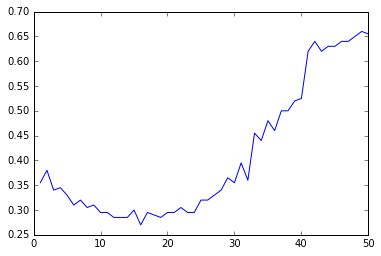

In [4]:
y = crossValidationkNN(traindata,trainlabels,50)
x = np.linspace(1, 50, 50)
#print(x.shape[0], y[])
pylab.plot(x,y[1:])

Select the number of neighbors which minimizes the cross-validation error. What is the cross-validation error for this number of neighbors? <b>(5 points)</b>

In [5]:
print (min(y) , " is the lowest error at k = " , np.argmin(y))

(0.27000000000000002, ' is the lowest error at k = ', 16)


K = 16, error is 0.27 or 27% which is the lowest

Train a kNN model on the whole training data using the number of neighbors you found in the previous part of the question, and apply it to the test data. How does the test error compare to the cross-validation error you found in the last part of the problem? <b>(5 points)</b>

For some ideas as to "why" you have this result, see section 7.10 of Elements of Statistical Learning, 2e, by Hastie et. al.

In [6]:
 classifier = neighbors.KNeighborsClassifier(16)
 fits = classifier.fit(traindata,trainlabels)
 result = fits.predict(testdata)
 print(classifierError(result,testlabels))

0.206


The test error is lower than the crossvalidation error, it is only 0.206 or about 21%

### Problem 2: SVM's, Model Selection & Assessment (40 points)

In this problem, you will be training a few SVM's with <a href="http://scikit-learn.org/stable/modules/svm.html#svm">sklearn.svm</a> in order to perform model selection and assessment. 

You will be using sklearn.svm.SVC for non-linear kernels and sklearn.svm.LinearSVC for linear kernels. Your model selection  will be done with cross-validation via sklearn.cross_validation's cross_val_score. This returns the accuracy for each fold, i.e. the fraction of samples classified correctly. Thus, the cross-validation error is simply 1-mean(cross_val_score).

All cross-validation should be 5-fold cross-validation.

<b>Warning: This problem may require a lot of time to train the SVM's. Do not put this off until the last minute.</b>

First, we load some data (acquired from <a href="https://archive.ics.uci.edu/ml/datasets/Spambase">here</a>). We will use scikit-learn's train test split function to split the data. The data is scaled for reasons outlined <a href="http://www.csie.ntu.edu.tw/~cjlin/papers/guide/guide.pdf">here</a>. In short, it helps avoid some numerical issues and avoids some problems with certain features which are typically large affecting the SVM optimization problem unfairly compared to features which are typically small. 

In [7]:
from sklearn.cross_validation import train_test_split
spambase= genfromtxt('spambase.data', delimiter=',')

spambase_features=spambase[:,:-1]
spambase_labels=spambase[:,-1]

#The training data is in data_train with labels label_train. The test data is in data_test with labels label_test.
data_train, data_test, label_train, label_test = train_test_split(spambase_features,spambase_labels,test_size=0.2,random_state=372015)

# Rescale the training data and scale the test data correspondingly
scaler=MinMaxScaler(feature_range=(-1,1))
data_train=scaler.fit_transform(data_train) #Note that the scaling is determined solely via the training data!
data_test=scaler.transform(data_test)

Train a linear SVM with sklearn.svm.LinearSVC on the training data with the parameter $C$ varied from $2^{-5},2^{-4},\ldots,2^{15}$. Which value of $C$ would you choose (and why), and what is its cross-validation error? The parameter $C$ controls how much points can be within the margin. <b>(10 points)</b>

In [13]:
#Put your code here
begin = -5
end =  15
error = err=np.zeros(1+((end - begin)) )
count = 0
for i in xrange(begin,end + 1):
    r = 2**i
    clf = svm.LinearSVC(C=r)
    scores=cross_validation.cross_val_score(
    clf, data_train, label_train, cv=5)
    error[count] = 1-mean(scores)
    count = count + 1
print(min(error), "was the lowest error at C= ", 2**(-5 +(np.argmin(error))))


(0.075815217391304257, 'was the lowest error at C= ', 4)


The value of C I would choose would be C=4 as it had the lowest crossvalidation score

You will now experiment with kernels. Using sklearn.svm.SVC, calculate the cross-validation error of a SVM using a RBF with parameters $(C,\gamma)$ varied over $C=2^{-5},2^{-4},\ldots,2^{15}$ and $\gamma=2^{-15},\ldots,2^{3}$ [So, you will try about 400 parameter choices]. Out of these, which was the best? What was its cross-validation error? This procedure is known as a *grid search*.

The parameter $C$ controls the amount points can be within the margin, while $\gamma$ is a parameter in the RBF. <b>(10 points)</b>

In [45]:
#Put your code here
#Put your code here
begin_c = -5
end_c =  15
begin_g = -15
end_g = 3
error_rbf = err=np.zeros((1 +(end_g-begin_g),1+(end_c - begin_c)) )
print(error_rbf.shape)
g_count = 0
for g in xrange(begin_g,end_g + 1):    
    c_count = 0
    for i in xrange(begin_c,end_c + 1):
        r = 2**i
        l = 2**g
        clf = svm.SVC(C=r,gamma = l)
        scores=cross_validation.cross_val_score(
        clf, data_train, label_train, cv=5)
        error_rbf[g_count,c_count] = 1-mean(scores)
        c_count = c_count + 1
    g_count = g_count +1
lowest_error = np.amin(error_rbf)
t =np.unravel_index(error_rbf.argmin(), error_rbf.shape)
c_loweest_error =2**(-5 +(t[1]))
g_loweest_error =2**(-15 + t[0])
print("Lowest Parameters: ")
print( "C = ",c_loweest_error,"G = ",g_loweest_error)

Lowest Parameters: 
('C = ', 16384, 'G = ', 0.015625)


In [64]:
print (lowest_error)

0.058152173913


The lowest error parameters were C = 16384 = 2^14 , G = 0.015625 = 2^-6 with cross validation error 0.058152173913

Now, estimate the cross-validation error of applying LDA to this data.

Between the linear SVM, the SVM using RBF's from the previous part of the problem, and the LDA classifier, which would you choose to use? Why? Make sure to take into account error and computational considerations.<b>(10 points)</b>

In [65]:
clf_lda = LDA()
scores_lda=cross_validation.cross_val_score(
clf_lda, data_train, label_train, cv=5)
print (1 - mean(scores_lda))

0.108967391304


The lowest error was from SVM using RBF, but it took about 30 minutes to run completely on a beefy computer. The LDA ran the quickest, but it had about 11% error, which is significantly higher than both SVMs. The linear SVM was a healthy balance between the accuracy from using an SVM and the speed of an LDA, taking about 3-4 minutes to run. As such, if reasonable accuracy was a concern, I would pick the linear SVM, but if we  require a speedy solution with mostly correct predictions, an LDA works perfectly.

Use the parameters chosen in the previous problem to train a classifier on the whole training set. Then, estimate the prediction error using the test set. What is your estimate of the prediction error? How does it compare to the cross-validation error?  <b>(10 points)</b>

In [71]:
clf_svm_line = svm.LinearSVC(C=4)
clf_svm_line.fit(data_train,label_train)
predictions_line = clf_svm_line.predict(data_test)
print (classifierError(predictions_line,label_test))

clf_svm_rbf = svm.SVC(C=16384, gamma=0.015625)
clf_svm_rbf.fit(data_train,label_train)
predictions_rbf = clf_svm_rbf.predict(data_test)
print (classifierError(predictions_rbf,label_test))

0.0901194353963
0.0684039087948


Error for the linear svm with the optimized parameters was 0.09, which was also slightly higher than the cross validation error
Error for the rbf svm with the optimized parameters was 0.07, which was also slightly higher than the cross validation error
These results were about what we expected, as genaralisation error is usually higher.